# Categorization machine learning demo
The goal of this notebook is to use illustrate the basic mathods of setting up a neural network meant to categorize data. This will also demonstrate the creation of some basic plots to measure the success of the network. For this problem, we will use [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) to measure network performance.

In [1]:
import torch
from math import comb, ceil, floor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from tqdm import tqdm
from torchmetrics import ROC 
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC, BinaryF1Score

First, let's create some data to try and learn. 

In [2]:
x, y = make_classification(
    n_samples=100_000, n_features=8, n_redundant=2,
    n_informative=4,  n_clusters_per_class=2, n_classes=2,
    random_state=10_000
)

## Plotting out inputs
Now, let's look at our input variables plotted against each other by category. This can give us some intuition about how useful different variable cominations may or may not be.

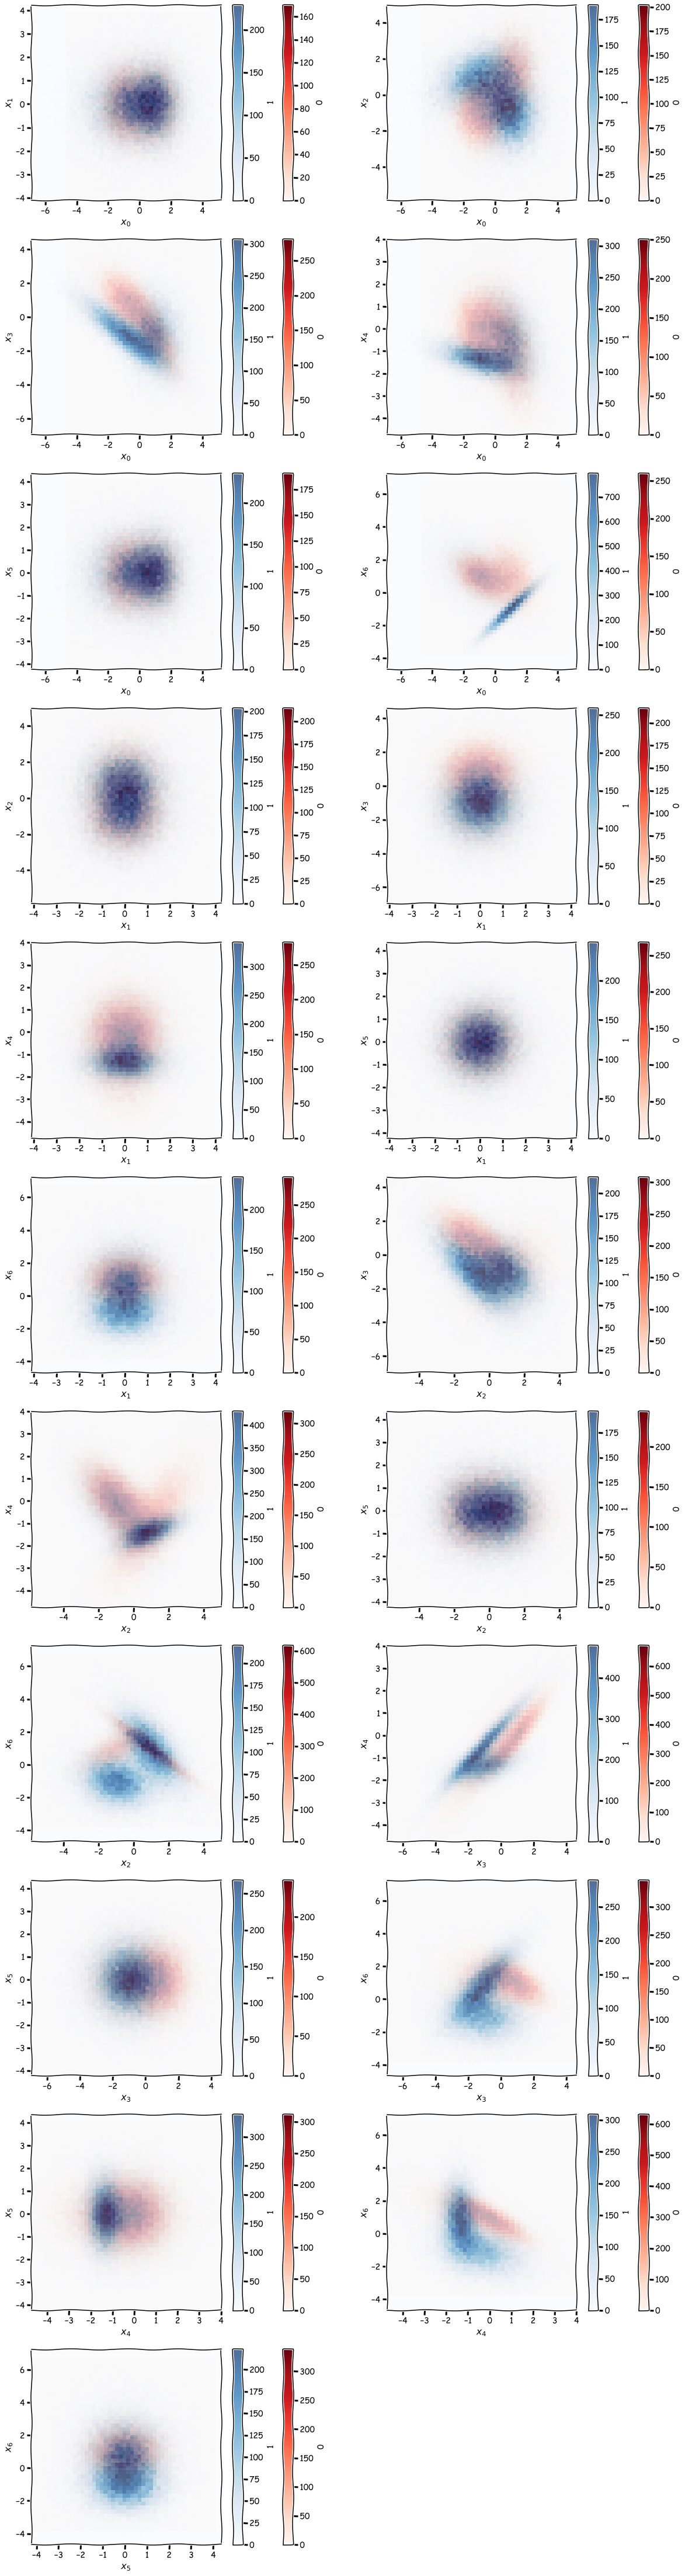

In [3]:
plt.rcParams['figure.figsize'] = [20, 80]

end = len(x[0,:]) - 1
index = 1
for i in range(0,end):
    for j in range(0,end):
        if (i != j) and (i < j):
            with plt.xkcd():
                plt.subplot(ceil(comb(end,2)/2),2,index)
                plt.hist2d(x[ y == 0][:,i], x[ y == 0][:,j], bins=50, cmap='Reds', alpha=1)
                plt.colorbar(label='0')
                plt.hist2d(x[ y == 1][:,i],x[ y == 1][:,j], bins=50, cmap='Blues', alpha=0.7)
                plt.colorbar(label='1')
                plt.xlabel(f'$x_{i}$', fontsize=16)
                plt.ylabel(f'$x_{j}$', fontsize=16)
            index += 1
plt.show()

### Outlining the parameters to train on

In [4]:
input_filter = [0,1,2,3,4,5,6,7]
train_ratio = 0.95
n_epochs = 2000
batch_size = 500
lr = 1e-5
n_nodes = 200

In [5]:
train, test   = torch.utils.data.random_split(torch.tensor(np.float32(np.column_stack([x, y]))), [train_ratio, 1 - train_ratio],
                                              generator=torch.Generator().manual_seed(42))

dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

model = torch.nn.Sequential(
    torch.nn.Linear(len(input_filter),n_nodes),
    torch.nn.ReLU(),
    torch.nn.Linear(n_nodes,1),
    torch.nn.Sigmoid()
)

model.train()

Sequential(
  (0): Linear(in_features=8, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=1, bias=True)
  (3): Sigmoid()
)

### Define our loss function and optimizer
We will be using the [Binary Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) Loss Function and the [ADAM Optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [6]:
lossFunc = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Start tracking our loss before training (epoch 0)

In [7]:
lossTrain = []
lossTest = []
lossIn = np.arange(0, n_epochs + 1, 1)

lossTrain.append(lossFunc(model(train[:][:,input_filter]).flatten(),train[:][:,-1]).detach().numpy())
lossTest.append(lossFunc(model(test[:][:,input_filter]).flatten(),test[:][:,-1]).detach().numpy())

### Train the Network

In [8]:
for epoch in tqdm(range(n_epochs)):
    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()
        prediction = torch.squeeze(model(batch[:,input_filter]))
        loss = lossFunc(prediction,batch[:,-1])
        loss.backward()
        optimizer.step()
    lossTrain.append((lossFunc(model(train[:][:,input_filter]).flatten(),train[:][:,-1])).detach().numpy())
    lossTest.append((lossFunc(model(test[:][:,input_filter]).flatten(),test[:][:,-1])).detach().numpy())

print('Training done!') 

100%|██████████| 2000/2000 [15:43<00:00,  2.12it/s]

Training done!


### Plot the loss as a function of epochs to measure network performance

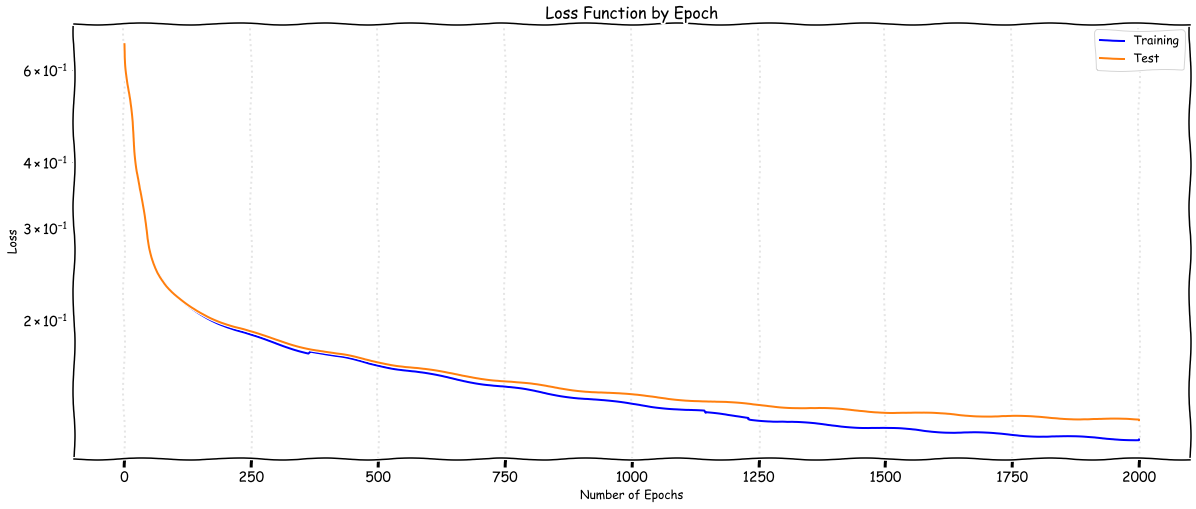

In [9]:
with plt.xkcd():
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.plot(lossIn, lossTrain, 'b', label='Training')
    plt.plot(lossIn, lossTest, 'tab:orange', label='Test')
    plt.grid(b=True, color='grey', alpha=0.2, linestyle=':', linewidth=2)
    plt.xlabel('Number of Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.yscale('log')
    plt.title('Loss Function by Epoch', fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.show()

### Create ROC curves to measure performance
ROC stands for Receiver Operating Characteristic curve. This plots true postive rate as a function of false positive rate. A perfectly performing classifier will look like the upper left corner of a rectangle.



Accuracy:       0.9598000049591064
Area Under ROC: 0.9889440536499023
F1 Score:       0.9595166444778442


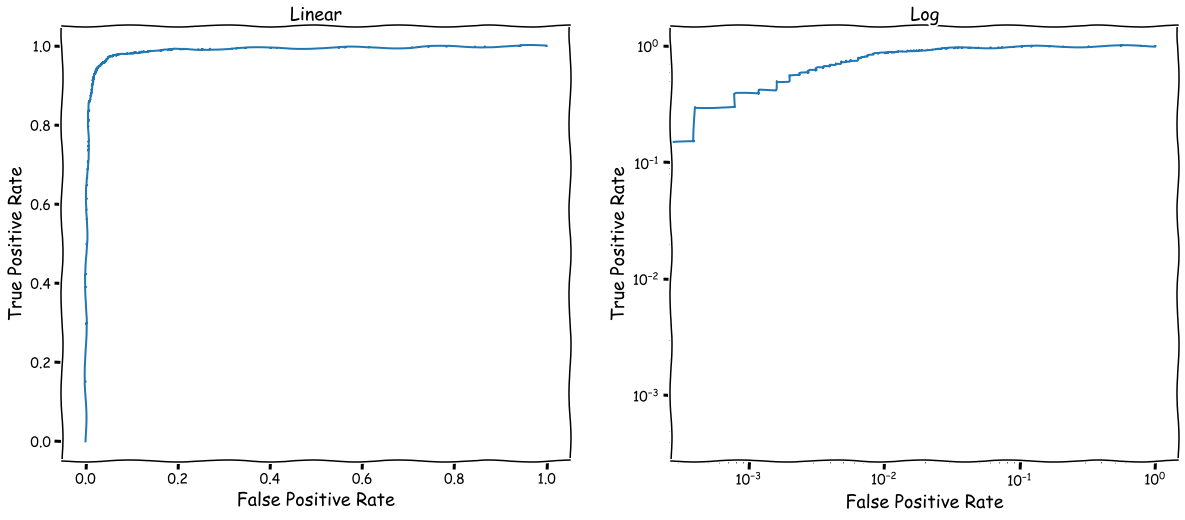

In [10]:
pred = torch.squeeze(model(test[:][:,input_filter])).detach()

roc = ROC(pos_label=1, task='binary')
fpr, tpr, thresholds = roc(pred, test[:][:,-1].int())


ac  = BinaryAccuracy()
auc = BinaryAUROC(thresholds=None)
f1  = BinaryF1Score()

print(f'Accuracy:       {ac(pred, test[:][:,-1].int())}')
print(f'Area Under ROC: {auc(pred, test[:][:,-1].int())}')
print(f'F1 Score:       {f1(pred, test[:][:,-1].int())}')


with plt.xkcd():
    plt.rcParams['figure.figsize'] = [20, 8]

    plt.subplot(1,2,1)
    plt.plot(fpr, tpr)
    plt.title('Linear', fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)

    plt.subplot(1,2,2)
    plt.plot(fpr, tpr)
    plt.title('Log', fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.xscale('log')
    plt.yscale('log')